# ChromVAR Affinity

Run ChromVAR for high and low affinity OSK motifs.

In [4]:
library(chromVAR)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Matrix)
library(SummarizedExperiment)
library(motifmatchr)
library(ggplot2)
library(scales)
library(ggseqlogo)
library(BiocParallel)
set.seed(2021)

In [5]:
register(MulticoreParam(20, progressbar = TRUE))

## Load Data

In [6]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20201022_n53906/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  53906 414473

In [7]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 53906     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AACGCGAGAAGGACCA,AACGCGAGAAGGACCA,D0,8.373301,-4.292619,5,D0_AACGCGAGAAGGACCA
D0_AACGCGCTGTCTGTGA,AACGCGCTGTCTGTGA,D0,2.033609,-7.860645,5,D0_AACGCGCTGTCTGTGA
D0_ACCTATGGACTCGATA,ACCTATGGACTCGATA,D0,3.093788,-7.469210,5,D0_ACCTATGGACTCGATA
D0_ACGCAGAGATAACCCA,ACGCAGAGATAACCCA,D0,6.001364,-7.523576,5,D0_ACGCAGAGATAACCCA
D0_ACTCGCTACTTGTGAC,ACTCGCTACTTGTGAC,D0,3.343237,-8.114589,5,D0_ACTCGCTACTTGTGAC


In [8]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 414473      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_10268_10885,chr1,10268,10885,chr1_10268_10885
chr1_41988_42505,chr1,41988,42505,chr1_41988_42505
chr1_46058_46558,chr1,46058,46558,chr1_46058_46558
chr1_48200_48959,chr1,48200,48959,chr1_48200_48959
chr1_51306_52190,chr1,51306,52190,chr1_51306_52190
chr1_58644_59144,chr1,58644,59144,chr1_58644_59144


In [9]:
peaks_gr = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))
peaks_gr

GRanges object with 414473 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       10268-10885      *
       [2]     chr1       41988-42505      *
       [3]     chr1       46058-46558      *
       [4]     chr1       48200-48959      *
       [5]     chr1       51306-52190      *
       ...      ...               ...    ...
  [414469]     chrY 25399010-25399553      *
  [414470]     chrY 25410561-25411061      *
  [414471]     chrY 26220958-26221458      *
  [414472]     chrY 26315008-26315508      *
  [414473]     chrY 26670870-26671408      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [10]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [11]:
pmatRowSums = Matrix::rowSums(pmat)

In [12]:
pmatColSums = Matrix::colSums(pmat)

In [13]:
min(pmatRowSums)

[1] 222

In [14]:
min(pmatColSums)

[1] 15

### Make motifs x peak matrix

Take OCTSOX/KLF/other motif hits in peaks in D2 (high OSK) not in fibroblasts. Split into high and low affinity and perform separately.

In [15]:
high_OSK_OCTSOX_hits = read.table("../20210520_spacing_in_data/scanning/tfmodisco_cluster_idx4_gc_neg_peak_set_8_10_11_13/high_OSK.not.fibr.1000.OCTSOX.top_oneperc_imp.bed")
# high_OSK_OCTSOX_hits = read.table("../20210520_spacing_in_data/scanning/tfmodisco_cluster_idx4_gc_neg_peak_set_8_10_11_13/high_OSK.not.fibr.1000.KLF.top_oneperc_imp.bed")
# high_OSK_OCTSOX_hits = read.table("../20210520_spacing_in_data/scanning/homer_motifs/high_OSK.not.fibr.1000.HNF.lower.thresh.bed") # control
colnames(high_OSK_OCTSOX_hits) = c("chr", "start", "end", "strand", "score", "seq")
high_OSK_OCTSOX_hits = GRanges(high_OSK_OCTSOX_hits)
head(high_OSK_OCTSOX_hits)

GRanges object with 6 ranges and 2 metadata columns:
      seqnames          ranges strand |     score             seq
         <Rle>       <IRanges>  <Rle> | <numeric>        <factor>
  [1]     chr1   840140-840154      - |  7.240431 ATATACTTGACAATA
  [2]     chr1 1191779-1191793      + |  6.785524 TATAGATATTCAGTT
  [3]     chr1 1638777-1638791      + |  6.882483 CTTTATTATGAAACA
  [4]     chr1 1801922-1801936      - |   7.47269 ATTAGTATCAGAAAA
  [5]     chr1 1828464-1828478      - |  6.104234 ATGTACACAACAATC
  [6]     chr1 1889037-1889051      - |  9.748941 CTATGCATGTCAATA
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [16]:
length(high_OSK_OCTSOX_hits)

[1] 145616

In [17]:
quantile(high_OSK_OCTSOX_hits$score, c(.25,.5,.95))

25%       50%       95% 
 6.639807  7.376563 10.036948

In [18]:
# motif strengths will be split into these percentile buckets
SPLITS = c(0,0.2,.4,.6,.8,.9,.95)

In [19]:
motif_x_peak = matrix(0, nrow = length(peaks_gr), ncol=length(SPLITS))

for (i in seq(length(SPLITS))) {
    cur_perc = SPLITS[i]
    cur_hits = high_OSK_OCTSOX_hits[high_OSK_OCTSOX_hits$score >= quantile(high_OSK_OCTSOX_hits$score, cur_perc)]
    motif_x_peak[unique(queryHits(findOverlaps(peaks_gr, cur_hits))), i] = 1
}

In [20]:
colSums(motif_x_peak)

[1] 69245 62852 53889 41554 24227 13041  6774

In [21]:
table(rowSums(motif_x_peak))


     0      1      2      3      4      5      6      7 
345228   6393   8963  12335  17327  11186   6267   6774 

In [22]:
# assign each peak to strongest
for (i in rev(2:length(SPLITS))) {
    motif_x_peak[motif_x_peak[,i]>0, 1:i-1] = 0
}

In [23]:
colSums(motif_x_peak)

[1]  6393  8963 12335 17327 11186  6267  6774

In [24]:
min(colSums(motif_x_peak))

[1] 6267

In [25]:
table(rowSums(motif_x_peak))


     0      1 
345228  69245 

In [26]:
colSums(motif_x_peak)

[1]  6393  8963 12335 17327 11186  6267  6774

In [27]:
dim(motif_x_peak)

[1] 414473      7

In [31]:
motif_hits_se <- SummarizedExperiment(
                 assays = list(motifMatches = motif_x_peak), 
                 colData = DataFrame(name=SPLITS)
    );

## ChromVAR

In [28]:
GENOME = BSgenome.Hsapiens.UCSC.hg38

In [29]:
rse <- SummarizedExperiment(
                 assays = list(counts = t(pmat)), 
                 rowRanges = peaks_gr, 
                 colData = DataFrame(Cell_Type=1:nrow(pmat), depth=pmatRowSums)
    );

In [30]:
rse <- addGCBias(rse, genome = GENOME);

Use pre-computed matrix, e.g. from BPNet hits loaded above

In [32]:
motif_mm <- motif_hits_se

---

In [33]:
motif_mm_mat = assay(motif_mm)
colnames(motif_mm_mat) = motif_mm$name

In [34]:
dev <- computeDeviations(object = rse, annotations = motif_mm)

Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



In [35]:
dev_mat = t(assay(dev))

In [36]:
colnames(dev_mat) = motif_mm$name
rownames(dev_mat) = rownames(metaData)
head(dev_mat)

,0,0.2,0.4,0.6,0.8,0.9,0.95
D0_AACGCGAGAAGGACCA,-0.4203053,-0.4343360,-0.3892896,-0.5139402,-0.6404598,-0.6119361,-0.6975009
D0_AACGCGCTGTCTGTGA,-0.3886531,-0.5915370,-0.4993566,-0.4629903,-0.5853039,-0.6483710,-0.7175977
D0_ACCTATGGACTCGATA,-0.5285405,-0.5643328,-0.4913244,-0.5506042,-0.5862758,-0.5959563,-0.7680390
D0_ACGCAGAGATAACCCA,-0.3795599,-0.4494486,-0.5472916,-0.5990555,-0.5853758,-0.6585178,-0.7602947
D0_ACTCGCTACTTGTGAC,-0.5518938,-0.3286072,-0.5792664,-0.4200756,-0.5964062,-0.5046456,-0.7844081
D0_AGACTACTGGCAGTTT,-0.4162050,-0.4146319,-0.4612920,-0.5406734,-0.6375373,-0.7005472,-0.7494457


In [989]:
# save output
# write.table(dev_mat, file="./out/20201020_n62402/20201119_bpnet.no_iPSC.FDR_0.1_hits.tsv", quote=F, row.names=T, sep='\t')

In [875]:
# variability <- computeVariability(dev)

In [876]:
# head(variability)

In [717]:
# plotVariability(variability, use_plotly = FALSE, n = 20) 

In [582]:
# variability[rev(order(variability$variability)), "name"]

In [662]:
cur_pattern = "0.8"

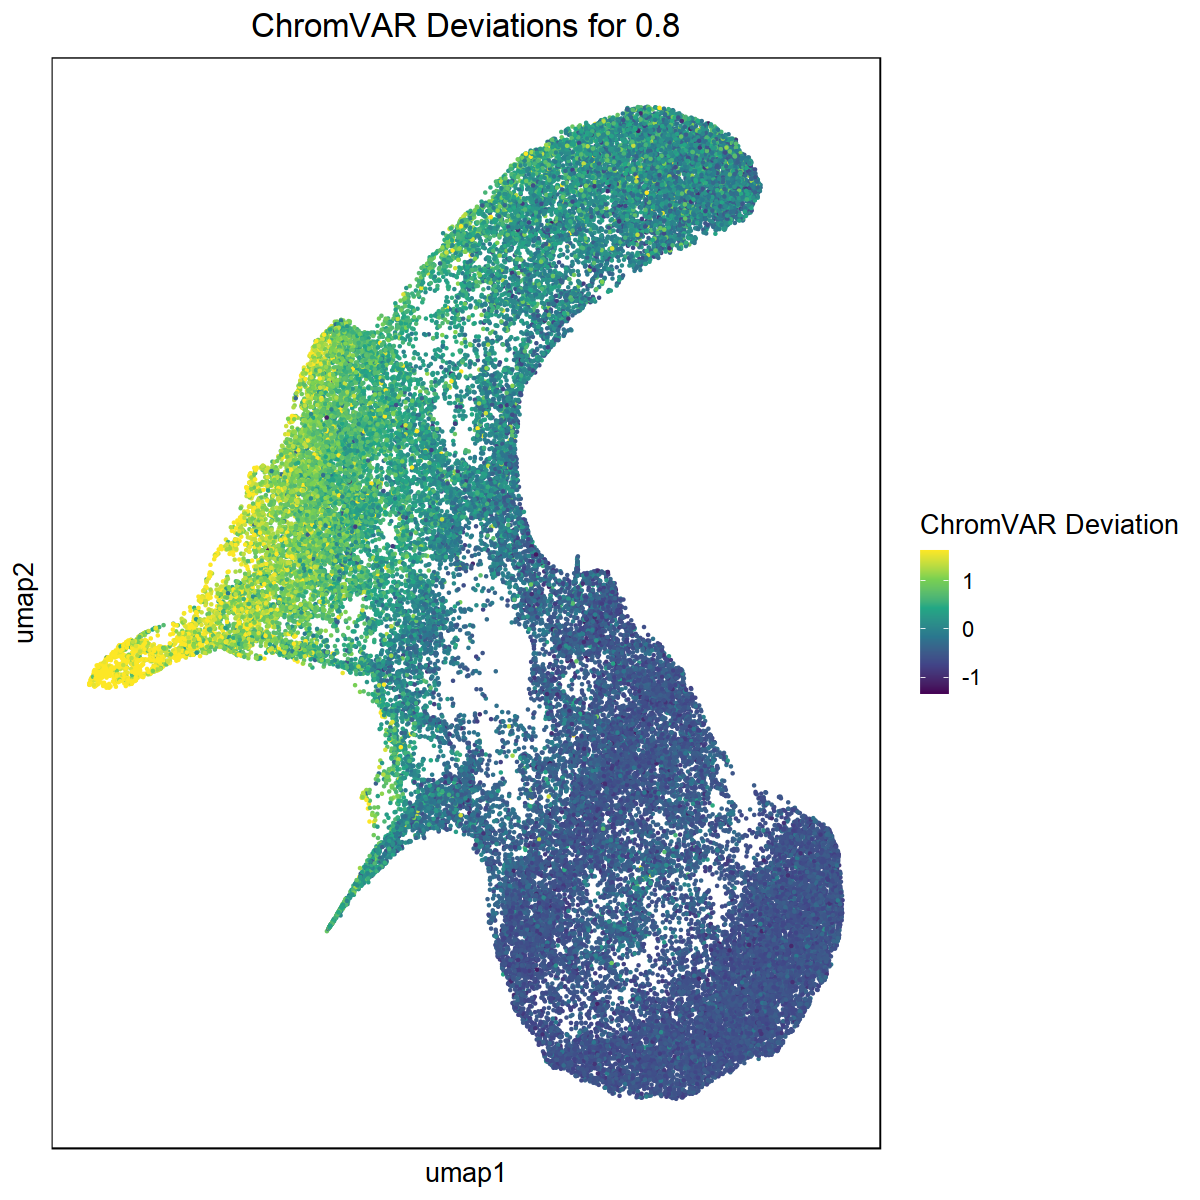

In [663]:
options(repr.plot.width = 10, repr.plot.height = 10)

cur_dev = dev_mat[,cur_pattern]

df = data.frame(metaData, n=cur_dev)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=1, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(cur_dev, 0.0),
                              quantile(cur_dev, 0.98)), 
                      oob = squish, name='ChromVAR Deviation') +
ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
theme_classic(base_size = 16) +
theme(plot.title = element_text(hjust = 0.5),
     axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
     panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

# ggsave("tmp.png", height=10, width=10)

In [664]:
sum(motif_mm_mat[, cur_pattern])

[1] 2898

In [665]:
frip = 100*Matrix::rowSums(pmat[, which(motif_mm_mat[, cur_pattern]>0)])/pmatRowSums

In [666]:
cor(frip, dev_mat[,cur_pattern], method='spearman')

[1] 0.9750202

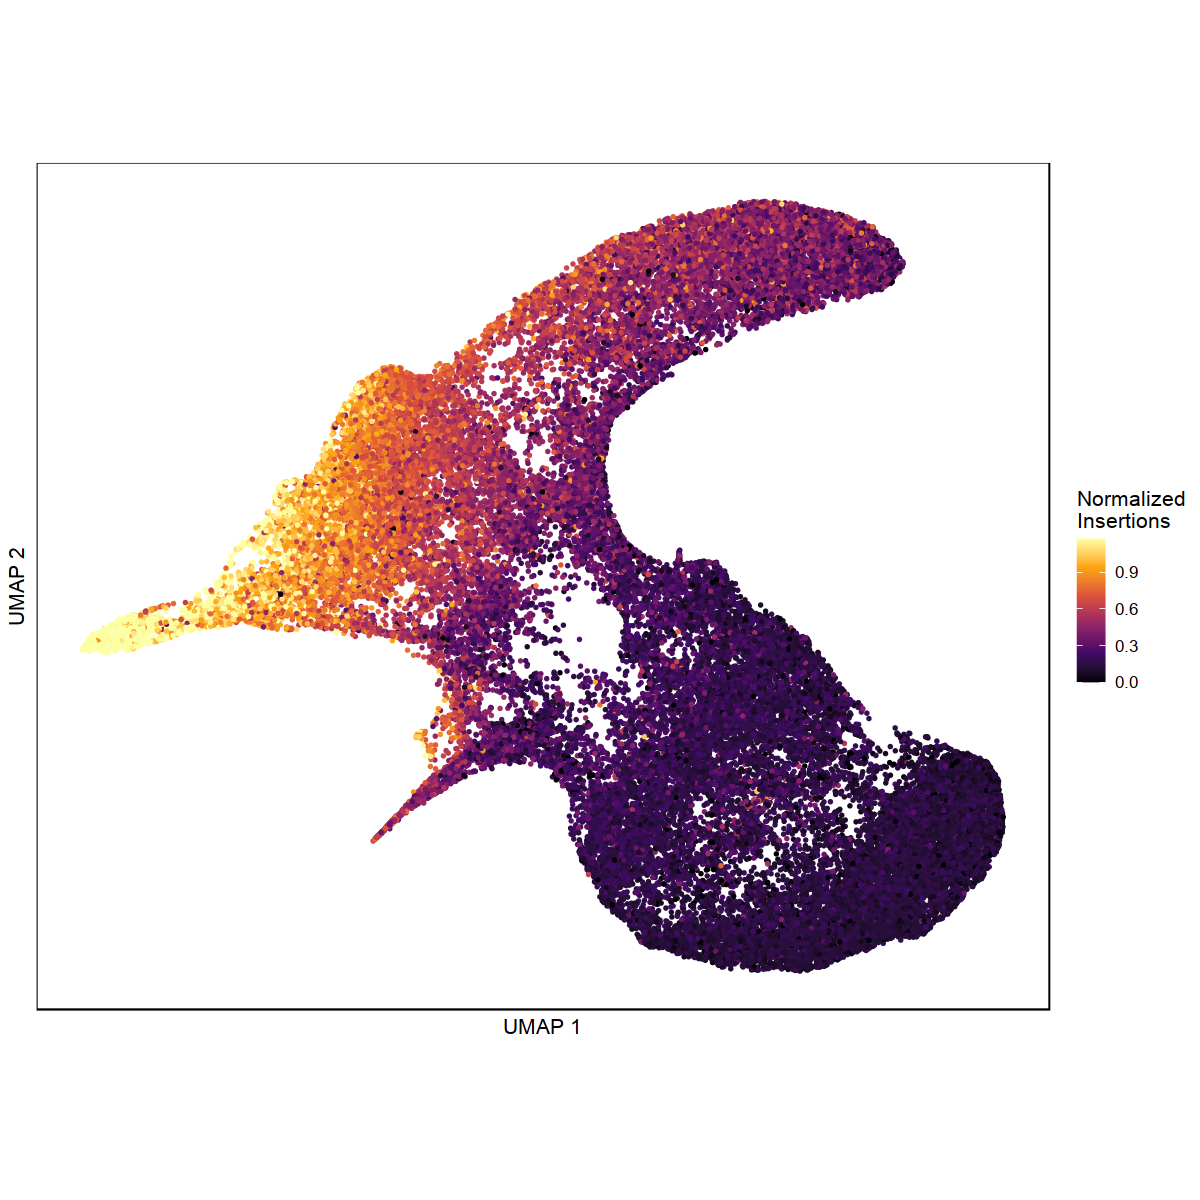

In [667]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(metaData, n=frip)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

frip_plot <- ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(frip, 0.00),
                              quantile(frip, 0.98)), 
                      oob = squish, option="B",
                     name="Normalized\nInsertions") +
theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
# ggtitle(sprintf("FRiP for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) +
coord_fixed()

frip_plot

In [41]:
library(reshape2)

In [42]:
colSums(is.na(dev_mat))

0  0.2  0.4  0.6  0.8  0.9 0.95 
   0    0    0    0    0    0    0

In [43]:
# if there's an NA
dev_mat[(is.na(dev_mat[,"0.8"])), "0.8"] = mean(dev_mat[,"0.8"], na.rm=T)
dev_mat[(is.na(dev_mat[,"0.9"])), "0.9"] = mean(dev_mat[,"0.9"], na.rm=T)
dev_mat[(is.na(dev_mat[,"0.95"])), "0.95"] = mean(dev_mat[,"0.95"], na.rm=T)

In [44]:
colSums(is.na(dev_mat))

0  0.2  0.4  0.6  0.8  0.9 0.95 
   0    0    0    0    0    0    0

In [45]:
cluster_mean = aggregate(dev_mat, list(metaData$cluster), mean)
rownames(cluster_mean) = cluster_mean[,"Group.1"]
cluster_mean = cluster_mean[,2:ncol(cluster_mean)]
# cluster_mean[,"Group.1"] = NULL
cluster_mean_norm = t(t(cluster_mean) - colMins(as.matrix(cluster_mean)))
cluster_mean_norm = t(t(cluster_mean_norm)/colMaxs(as.matrix(cluster_mean_norm))) # norm to 0-1

colnames(cluster_mean_norm) = paste(colnames(cluster_mean_norm), c(colnames(cluster_mean_norm)[2:ncol(cluster_mean_norm)],1), sep='-')                              

In [46]:
ORDER = c(4,8,2,7,1,5)
ordered_vals = as.data.frame(cluster_mean_norm[ORDER,])

# change rownames to order of samples
rownames(ordered_vals) = rev(seq(nrow(ordered_vals)))

ordered_vals

,0-0.2,0.2-0.4,0.4-0.6,0.6-0.8,0.8-0.9,0.9-0.95,0.95-1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9046131
5,0.4287765,0.4793190,0.5286479,0.6269933,0.7457081,0.8730425,1.0000000
4,0.3101938,0.3342552,0.3425745,0.3958336,0.4841967,0.5722182,0.7664735
3,0.1632911,0.1737702,0.1890762,0.2308963,0.2971678,0.3512172,0.5509326
2,0.1162298,0.1285766,0.1519673,0.1917512,0.2433862,0.2876495,0.4437867
1,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [47]:
sum(rowMaxs(as.matrix(ordered_vals))[2:6]-rowMins(as.matrix(ordered_vals))[2:6])

[1] 1.742701

In [48]:
to_plot = melt(as.matrix(ordered_vals))

In [49]:
head(to_plot)

,Var1,Var2,value
,<int>,<fct>,<dbl>
1,6,0-0.2,1.0000000
2,5,0-0.2,0.4287765
3,4,0-0.2,0.3101938
4,3,0-0.2,0.1632911
5,2,0-0.2,0.1162298
6,1,0-0.2,0.0000000


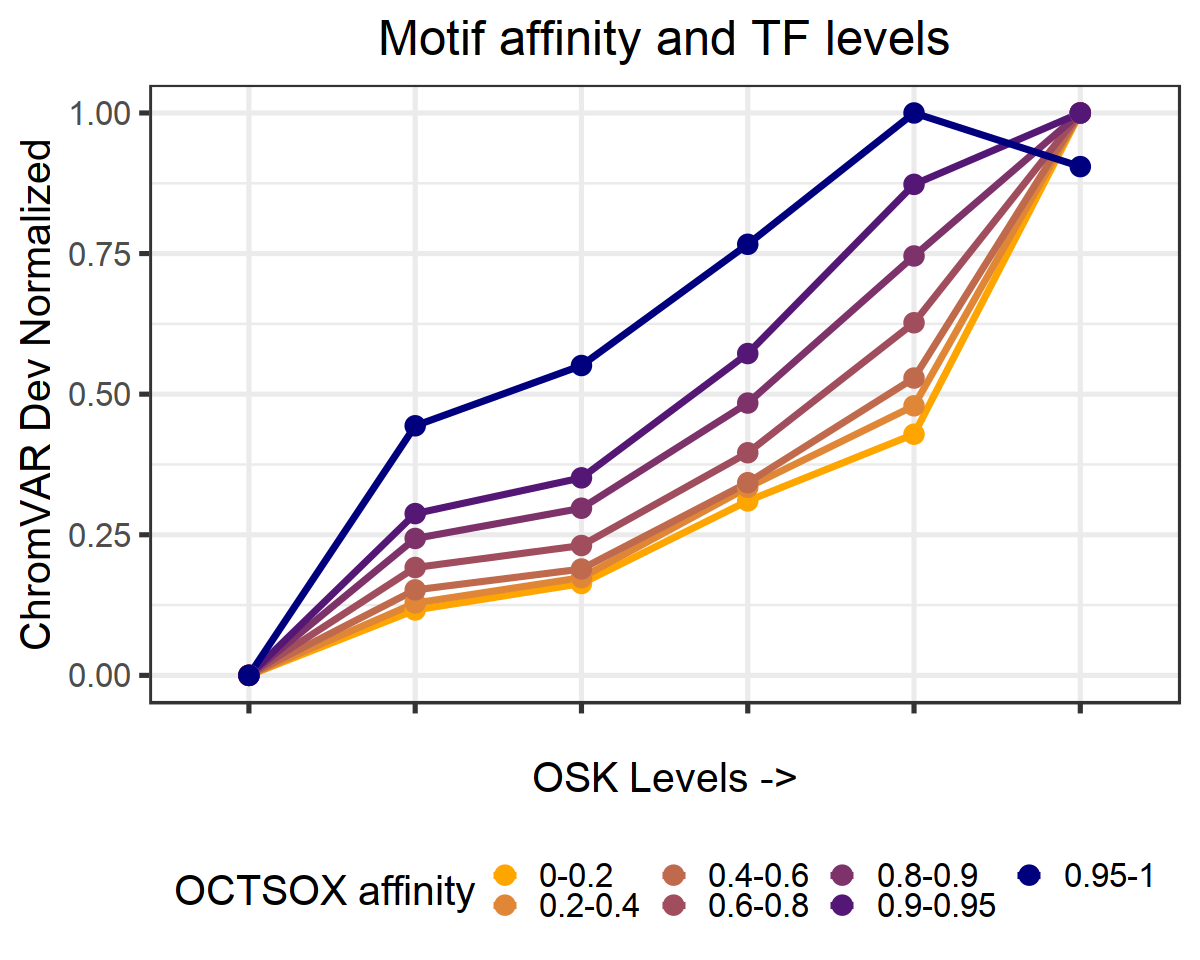

In [50]:
options(repr.plot.width = 10, repr.plot.height = 8)

p <- ggplot(to_plot, aes(x=factor(Var1), y=value, group=Var2, color=factor(Var2, 
                                                           levels=colnames(ordered_vals)))) +
geom_line(size=1.5) + 
geom_point(size=5) +
ylab("ChromVAR Dev Normalized") +
xlab("OSK Levels ->") +
theme_bw(base_size=24) +
ggtitle("Motif affinity and TF levels") +
# scale_color_brewer() +
scale_color_manual(values=colorRampPalette(c("orange","navyblue"), space = "Lab")(length(SPLITS))) +
labs(colour="OCTSOX affinity") +
theme(axis.text.x=element_text(color="white"),
     plot.title = element_text(hjust=0.5),
     legend.position = "bottom")

p

In [787]:
ggsave("tmp.pdf", p, height=8, width=10)

### Permuted Controls

In [ ]:
# 1 shuffle (for control)
# motif_x_peak[rowSums(motif_x_peak)==1,] = motif_x_peak[(rowSums(motif_x_peak)==1),][sample(sum(rowSums(motif_x_peak)==1)), ]

In [51]:
# multiple permuted controls (have to run in sets of 100)
control_spreads = c()

for (i in range(10)) {
    permuted_controls = list()
    for (i in seq(100)) {
        permuted_controls[[i]] = motif_x_peak
        permuted_controls[[i]][rowSums(motif_x_peak)==1,] = motif_x_peak[(rowSums(motif_x_peak)==1),][sample(sum(rowSums(motif_x_peak)==1)), ]
        colnames(permuted_controls[[i]]) = paste(i, SPLITS, sep='_')
     }

    permuted_controls = do.call(cbind, permuted_controls)
    
    motif_hits_se <- SummarizedExperiment(
                 assays = list(motifMatches = permuted_controls), 
                 colData = DataFrame(name=colnames(permuted_controls))
    );
    
    motif_mm <- motif_hits_se
    motif_mm_mat = assay(motif_mm)
    colnames(motif_mm_mat) = motif_mm$name
        
    dev <- computeDeviations(object = rse, annotations = motif_mm)
    dev_mat = t(assay(dev))
    
    colnames(dev_mat) = motif_mm$name
    rownames(dev_mat) = rownames(metaData)
    
    # aggregate over clusters
    cluster_mean = aggregate(dev_mat, list(metaData$cluster), mean)
    rownames(cluster_mean) = cluster_mean[,"Group.1"]
    cluster_mean = cluster_mean[,2:ncol(cluster_mean)]
    # cluster_mean[,"Group.1"] = NULL
    cluster_mean_norm = t(t(cluster_mean) - colMins(as.matrix(cluster_mean)))
    cluster_mean_norm = t(t(cluster_mean_norm)/colMaxs(as.matrix(cluster_mean_norm))) # norm to 0-1

    colnames(cluster_mean_norm) = paste(colnames(cluster_mean_norm), c(colnames(cluster_mean_norm)[2:ncol(cluster_mean_norm)],1), sep='-')
    
    ORDER = c(4,8,2,7,1,5)
    ordered_vals = as.data.frame(cluster_mean_norm[ORDER,])

    # change rownames to order of samples
    rownames(ordered_vals) = rev(seq(nrow(ordered_vals)))

    # compute spreads
    for (i in seq(100)) {
        cur = as.matrix(ordered_vals[,((i-1)*length(SPLITS)+1):(i*length(SPLITS))])
        control_spreads = c(control_spreads, sum(rowMaxs(cur)-rowMins(cur)))
    }
}

Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



Warning message in matches_check(annotations):
“Annotation object matches converted to logical”


  |======================================================================| 100%



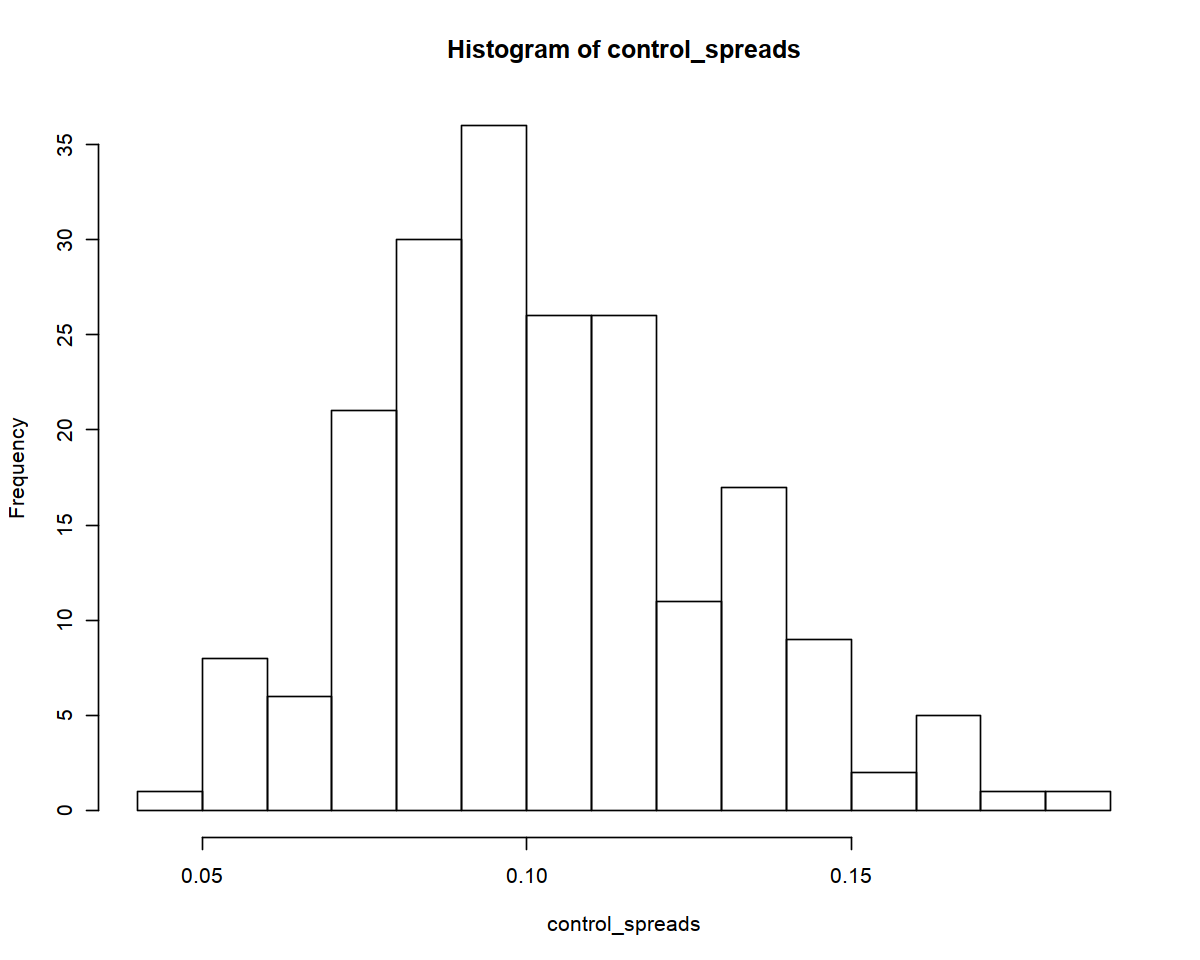

In [55]:
hist(control_spreads, breaks=13)

In [57]:
to_plot = melt(as.matrix(ordered_vals))

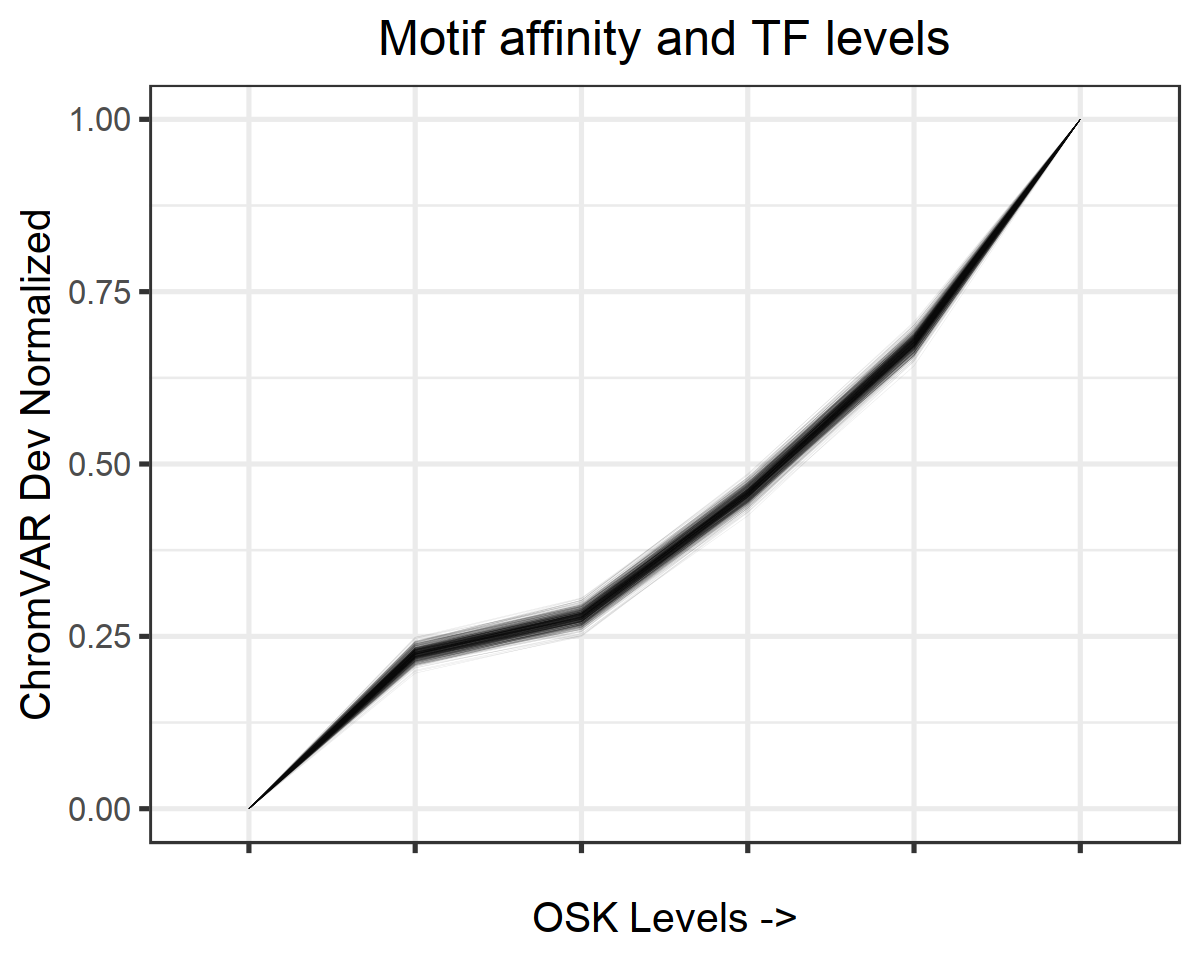

In [82]:
options(repr.plot.width = 10, repr.plot.height = 8)

p <- ggplot(to_plot, aes(x=factor(Var1), y=value, group=Var2)) +
geom_line(size=.1, color='black', alpha=.1) + 
# geom_point(size=5) +
ylab("ChromVAR Dev Normalized") +
xlab("OSK Levels ->") +
theme_bw(base_size=24) +
ggtitle("Motif affinity and TF levels") +
# scale_color_brewer() +
# scale_color_manual(values=colorRampPalette(c("orange","navyblue"), space = "Lab")(length(SPLITS)*100)) +
labs(colour="OCTSOX affinity") +
theme(axis.text.x=element_text(color="white"),
     plot.title = element_text(hjust=0.5),
     legend.position = "bottom")

p

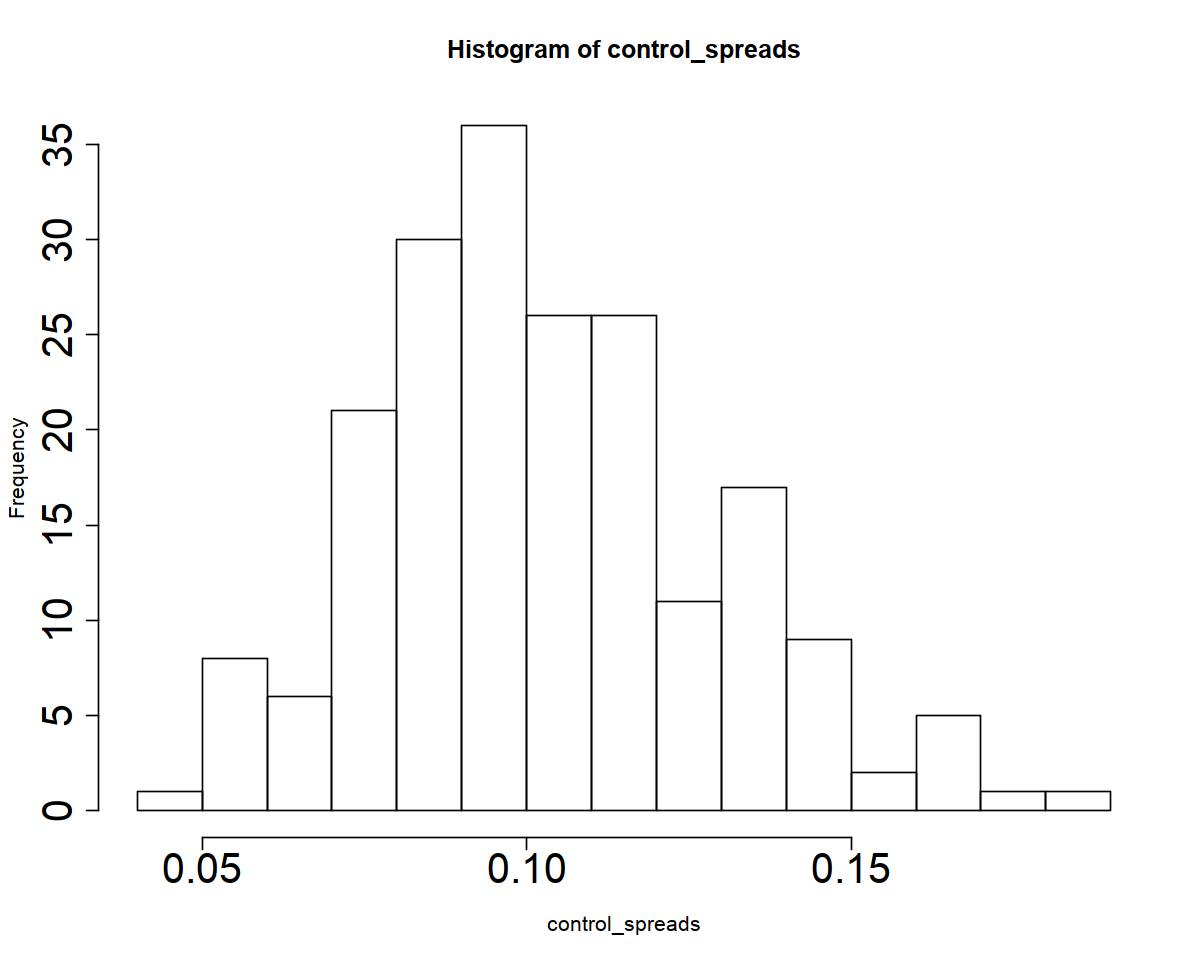

In [78]:
hist(control_spreads, breaks=10, cex.axis=2)

### SessionInfo

In [519]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] reshape2_1.4.4                    ggseqlogo_0.1                    
 [3] scales_1.1.0                      ggplot2_3.3.3                    
 [5] motifmatchr_1.8.0                 SummarizedExperiment_1.16.1      
 [7] DelayedArray_0.12.3               BiocParallel_1.20